# TUTORIAL: Real-time data assimilation
<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.4/MathJax.js?config=default'></script>

* [State and parameter estimation](#fifth)
    * [Augmented state-space formulation](#third)
    * [Augmented ensemble statistics](#ens)
* [Test case: twin experiment on a Van der Pol oscillator](#fifth-vdp)


In [6]:
import numpy as np
from scipy import linalg
from essentials.models_physical import VdP
rng = np.random.default_rng(0)


def EnKF(Af, d, Cdd, M):
    """Ensemble Kalman Filter as derived in Evensen (2009) eq. 9.27.
        Inputs:
            Af: forecast ensemble at time t
            d: observation at time t
            Cdd: observation error covariance matrix
            M: matrix mapping from state to observation space
        Returns:
            Aa: analysis ensemble (or Af is Aa is not real)
    """
    m = np.size(Af, 1)

    psi_f_m = np.mean(Af, 1, keepdims=True)
    Psi_f = Af - psi_f_m

    # Create an ensemble of observations
    D = rng.multivariate_normal(d, Cdd, m).transpose()

    # Mapped forecast matrix M(Af) and mapped deviations M(Af')
    Y = np.dot(M, Af)
    S = np.dot(M, Psi_f)

    # Matrix to invert
    C = (m - 1) * Cdd + np.dot(S, S.T)
    Cinv = linalg.inv(C)

    X = np.dot(S.T, np.dot(Cinv, (D - Y)))

    Aa = Af + np.dot(Af, X)

    return Aa


## 1. State and parameter estimation <a class="anchor" id="fifth"></a>

### Motivation: uncertain model parameters

In [7]:

from essentials.create import create_truth, create_ensemble

# True parameters
alpha_true = dict(beta = 70.,
                  kappa = 4.0,
                  zeta = 60.)

truth = create_truth(VdP, 
                     Nq=2,
                     t_start=1., 
                     t_stop=1.5, 
                     t_max=2.5, 
                     Nt_obs=30, 
                     std_obs = 0.1,
                     noise_type = 'gaussian, additive',
                     dt=2e-4,
                     psi0=rng.random(2),
                    **alpha_true
                    )


forecast_params = dict(model=VdP, 
                       Nq=2,                
                       m=20,               # Number of ensemble members
                       std_psi=.8,        # Initial uncertainty in the state
                      psi0=np.array([1, 1000]),
                       # Initial guess on the parameters
                       beta = 67.,
                       kappa = 4.0,
                       zeta = 65.,
                       )

ensemble = create_ensemble(**forecast_params)


In [8]:

filter_ens = ensemble.copy()

# Define measurement error covariance matrix

var_d  = [.1, 100]
Cdd = np.eye(filter_ens.Nq) * var_d


# ----------------------------------------------------------------------------

from essentials.DA import analysisStep
filter_ens.activate_parameter_estimation = True

for d, t_d in zip(truth['y_obs'], truth['t_obs']):
    # Parallel forecast to next observation
    Nt = int(np.round((t_d - filter_ens.get_current_time) / filter_ens.dt))
    psi, t = filter_ens.time_integrate(Nt)
    
    filter_ens.update_history(psi, t) 

    Af = np.vstack([filter_ens.get_current_state,
                   filter_ens.get_observables()]) # augmented state matrix [phi; alpha; q] x m
    
    # Perform assimilation 
    Aa = EnKF(Af, d, Cdd, filter_ens.M)  # Analysis step
    
    # Update the initial condition for the next forecast
    filter_ens.update_history(Aa[:-filter_ens.Nq, :],
                              update_last_state=True)
    
# ----------------------------------------------------------------------------

filter_ens.close() # closes the parallel pools


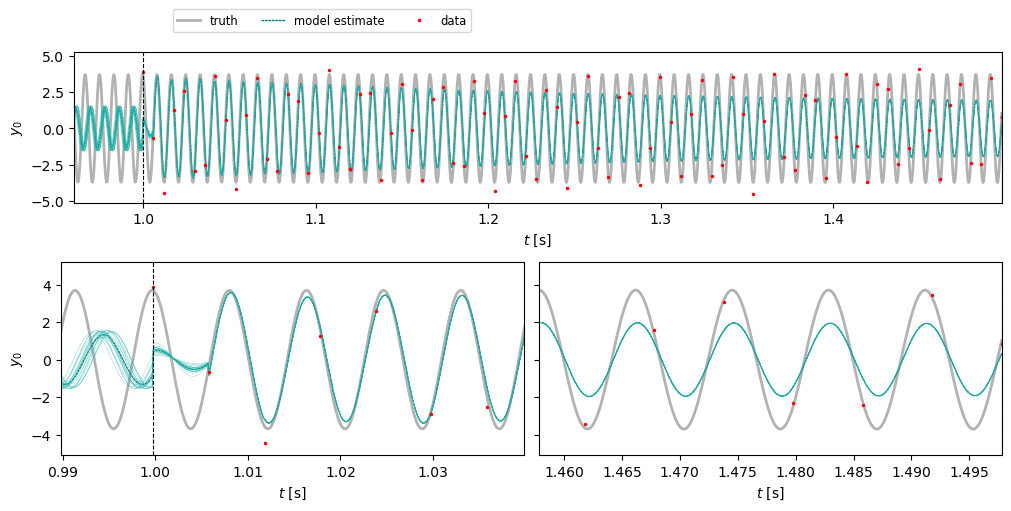

In [9]:
from essentials.plotResults import plot_timeseries
plot_timeseries(filter_ens, truth, plot_ensemble_members=True, dims=[0])


Therefore, we need to account for possible errors in the parameters. As discussed in the previois tutorial, we model aleatoric errors as Gaussian processes.

<br /> 

## 1.1 Augmented State-Space Formulation <a name="third"></a>

To estimate both the state $\boldsymbol{\phi}$ and parameters $\boldsymbol{\alpha}$, we define an **augmented state vector**:

$$
\boldsymbol{\psi} = \begin{bmatrix} \boldsymbol{\phi} \\ \boldsymbol{\alpha} \\ \mathbf{q} \end{bmatrix}
$$

We can treat the parameters as state variables which are constant in time, such that the augmented state-space formulation reads

$$
\left\{
\begin{aligned}
\mathrm{d}
\begin{bmatrix}
\boldsymbol{\phi} \\
\boldsymbol{\alpha} \\
\mathbf{q}
\end{bmatrix}
&=
\begin{bmatrix}
\mathcal{F}(\boldsymbol{\phi} + \boldsymbol{\epsilon}_\phi, \boldsymbol{\alpha} + \boldsymbol{\epsilon}_\alpha) \\
\mathbf{0}_{N_\alpha} \\
\mathbf{0}_{N_q}
\end{bmatrix} \mathrm{d}t \\
\mathbf{q} &= \mathcal{M}(\boldsymbol{\phi}) + \boldsymbol{\epsilon}_q
\end{aligned}
\right.
\quad \leftrightarrow \quad
\left\{
\begin{aligned}
\mathrm{d}\boldsymbol{\psi} &= \mathbf{F}(\boldsymbol{\psi} + \boldsymbol{\epsilon}_\psi)\mathrm{d}t \\
\mathbf{q} &= \mathbf{M} \boldsymbol{\psi} + \boldsymbol{\epsilon}_q
\end{aligned}
\right.
$$

Here:
- $\mathbf{F}$: augmented nonlinear operator  
- $\boldsymbol{\epsilon}_\psi$: augmented uncertainty  
- $\mathbf{M} = \begin{bmatrix} \mathbf{0} & \mathbb{I}_{N_q} \end{bmatrix}$: linear measurement operator  

This augmented state-space approach effectively linearises the nonlinear observation operator around the point of observation, which  simplifies the derivation of data assimilation methods. 


## 1.2 Augmented ensemble statistics <a name="ens"></a>

$$
\begin{align}
	 \mathbb{E}(\boldsymbol{\psi})\approx\bar{\boldsymbol{\psi}}=\dfrac{1}{m}\sum^m_{j=1}{\boldsymbol{\psi}_j} 
	  \quad \text{and} \quad
	 \mathbf{C}_{\psi\psi} = \begin{bmatrix}
				\mathbf{C}_{\phi\phi}  & \mathbf{C}_{\phi\alpha}& \mathbf{C}_{\phi q} \\
				\mathbf{C}_{\alpha \phi}  & \mathbf{C}_{\alpha\alpha}& \mathbf{C}_{\alpha q} \\
				\mathbf{C}_{q \phi}  & \mathbf{C}_{q \alpha}& \mathbf{C}_{q q} \\
			\end{bmatrix}
			\approx\dfrac{1}{m-1}\sum^m_{j=1}(\boldsymbol{\psi}_i-\bar{\boldsymbol{\psi}})\otimes(\boldsymbol{\psi}_i-\bar{\boldsymbol{\psi}}). 
\end{align}
$$
Each ensemble member $j$ is forecast independently in time with $\mathbf{F}(\boldsymbol{\psi}_j)$ to obtain an ensemble of forecast states $\boldsymbol{\psi}_j^\text{f}$. When a sensor provides noisy data $\mathbf{d}$,  real-time data assimilation statistically combines the noisy data and the forecast ensemble to improve our knowledge in the system's parameters and states (i.e., to compute an analysis ensemble $\boldsymbol{\psi}_j^\mathrm{a}$). Mathematically, we aim to minimize the cost function
$$
\begin{align}
\mathcal{J}(\boldsymbol{\psi}_j) = &\left\|\boldsymbol{\psi}_j-\boldsymbol{\psi}_j^\mathrm{f}\right\|^2_{\mathbf{C}^{\mathrm{f}^{-1}}_{\psi\psi}} +
 \left\|{\boldsymbol{y}}_j-\boldsymbol{d}_j\right\|^2_{\mathbf{C}^{-1}_{dd}}, \quad \mathrm{for} \quad j=0,\dots,m-1,
\end{align}
$$
where $\left\|\cdot\right\|^2_{\mathbf{C}^{-1}}$ is the L2-norm weighted by the semi-positive definite matrix $\mathbf{C}^{-1}$. The ensemble Kalman filter (EnKF) minimize the cost function to obtain an analysis ensemble $\boldsymbol{\psi}_j^\mathrm{a}$ from the forecast ensemble $ \boldsymbol{\psi}_j^\mathrm{f}$ and the observations $\mathbf{d}$ as
$$
\begin{align}
    \boldsymbol{\psi}_j^\mathrm{a} 
    &= \boldsymbol{\psi}_j^\mathrm{f}+\mathbf{K}\left[\mathbf{d}_j - \mathbf{M}\boldsymbol{\psi}_j^\mathrm{f}\right], \quad j=0,\dots,m-1,
\end{align}
$$
where $\mathbf{K}=\mathbf{C}_{\psi\psi}^\mathrm{f}\mathbf{M}^\mathrm{T}\left(\mathbf{C}_{dd}+\mathbf{M}\mathbf{C}_{\psi\psi}^\mathrm{f}\mathbf{M}^\mathrm{T}\right)^{-1}$ is the Kalman gain matrix.  


With this, the state and parameters can be updated directly fom the observations. Evaluating the terms with $\mathbf{M}$

$$
\begin{align}
	\begin{bmatrix}
	\boldsymbol{\phi}_j^\mathrm{a} \\\\
	\boldsymbol{\alpha}_j^\mathrm{a}  
	\end{bmatrix} 
	= 
	\begin{bmatrix}
	\boldsymbol{\phi}_j^\mathrm{f} \\ \\
	\boldsymbol{\alpha}_j^\mathrm{f}  
	\end{bmatrix} 
	+
	\begin{bmatrix}
	\mathbf{C}_{\phi q}^\mathrm{f}\\ \\
	\mathbf{C}_{\alpha q}^\mathrm{f}
	\end{bmatrix} \left(\mathbf{C}_{dd}+\mathbf{C}_{qq}^\mathrm{f}\right)^{-1}\left[\mathbf{d}_j - \boldsymbol{q}_j^\mathrm{f}\right]

\end{align}
$$

</p>

<br />





##  2. Test case: twin experiment on the Van der Pol oscillator <a class="anchor" id="fifth-vdp"></a>


The time evolution of the Van der Pol oscillator is governed by the second-order differential equation
\begin{align}
    \ddot{\eta} + \omega^2{\eta} =  \dot{q} - \zeta\dot{\eta}, 
\end{align}
where $\omega$ is the angular oscillating frequency, $\zeta$ is the damping coefficient, and $\dot{q}$ is a forcing term. One application of this system is thermoacoustic systems, in which  $\eta$ represents the acoustic velocity, and $\dot{q}$ is the heat release rate, which can be modelled as  
\begin{equation}
    \dot{q} = \beta\dot{\eta}\left(1 - \dfrac{\kappa\eta^2}{\beta + \kappa\eta^2}\right),
\end{equation}
 where $\kappa$ is the nonlinearity coefficient, and $\beta$ is the forcing strength. Using this heat release law, the Van der Pol oscillator can be written as the system of ordinary differential equations
\begin{equation}
\left\{
\begin{array}{rcl}
    \dfrac{\mathrm{d}\eta}{\mathrm{d} t} &=& \mu\\
    \dfrac{\mathrm{d}\mu}{\mathrm{d} t} &=& -\omega^2\eta + \mu \left(\beta - \zeta -\dfrac{\beta\kappa\eta^2}{\beta + {\kappa}\eta^2}\right).
\end{array}
\right.
\end{equation}
In state-space notation, the state vector is $\boldsymbol{\phi} = [\mu; \eta]$, the model parameters are $\boldsymbol{\alpha} = [\zeta; \beta; \kappa]$; and the model estimate (i.e., the measurable quantity) is the acoustic velocity $\eta$.  Therefore, the augmented vector to estimate is

$$
\begin{equation}
\boldsymbol{\psi} = 
\begin{bmatrix}
\boldsymbol{\phi}\\
\boldsymbol{\alpha}\\
\mathbf{q}
\end{bmatrix} = 
\begin{bmatrix}
{\mu}\\
{\eta}\\
\zeta\\
\beta\\
\kappa\\
\eta
\end{bmatrix} 
\end{equation}
$$


### Create forecast ensemble with uncertain parameters

In [10]:
from essentials.create import create_ensemble

fixed_params = dict(beta = 70.,
                  kappa = 4.0,
                  zeta = 60.)


alpha0 = dict(beta = (55., 90.),
              # kappa=(3.,4.5),
              # zeta=(60., 62.),
              )

for key in alpha0.keys():
    fixed_params.pop(key)


forecast_params = dict(model=VdP,
                       Nq = 2,           
                       m=100,              # Number of ensemble members
                       std_psi=0.1,        # Initial uncertainty in the state
                       std_a=alpha0,       # Initial uncertainty in the parameters
                       **fixed_params
                       )

ensemble = create_ensemble(**forecast_params)


### Apply data assimilation

In [11]:

rng = np.random.default_rng(0)


filter_ens = ensemble.copy()


# Define measurement error covariance matrix
std_d = 0.1 * np.max(abs(np.mean(filter_ens.get_observable_hist(), axis=-1)), axis=0)  

Cdd = np.diag(std_d ** 2)


# ----------------------------------------------------------------------------

for d, t_d in zip(truth['y_obs'], truth['t_obs']):
    # Parallel forecast to next observation
    Nt = int(np.round((t_d - filter_ens.get_current_time) / filter_ens.dt))
    psi, t = filter_ens.time_integrate(Nt)
    filter_ens.update_history(psi, t) 

    Af = np.vstack([filter_ens.get_current_state,
                   filter_ens.get_observables()]) # augmented state matrix [phi; alpha; q] x m
    
    # Perform assimilation 
    Aa = EnKF(Af, d, Cdd, filter_ens.M)  # Analysis step

    Aa_m = np.mean(Aa, axis=-1, keepdims=True)
    Aa = Aa_m + 1.01 * (Aa - Aa_m)
    
    # Update the initial condition for the next forecast
    filter_ens.update_history(Aa[:-filter_ens.Nq, :],
                              update_last_state=True)
    
# ----------------------------------------------------------------------------

filter_ens.close() # closes the parallel pools

#Forecast the ensemble further without assimilation
Nt_extra = int(filter_ens.t_CR / filter_ens.dt) 

psi, t = filter_ens.time_integrate(Nt_extra, averaged=False)
filter_ens.update_history(psi, t)



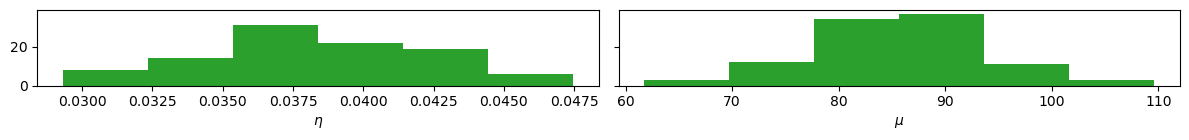

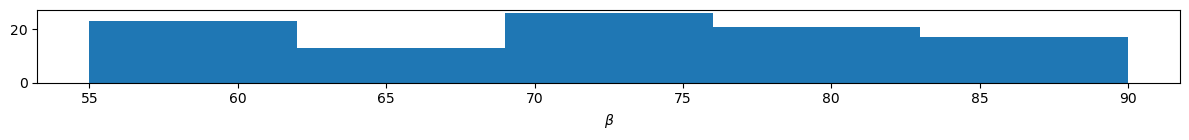

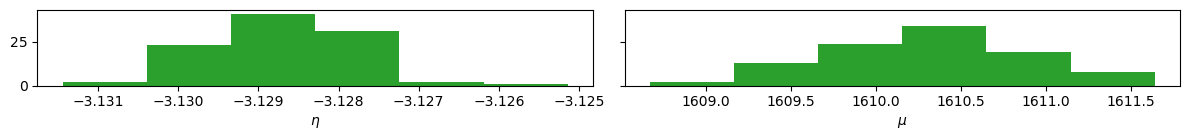

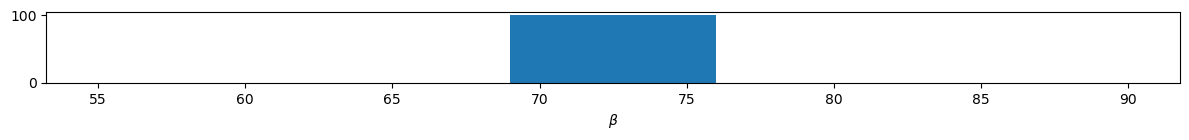

In [12]:
from essentials.plotResults import plot_ensemble

plot_ensemble(ensemble) # Initial ensemble
plot_ensemble(filter_ens) # Final ensemble

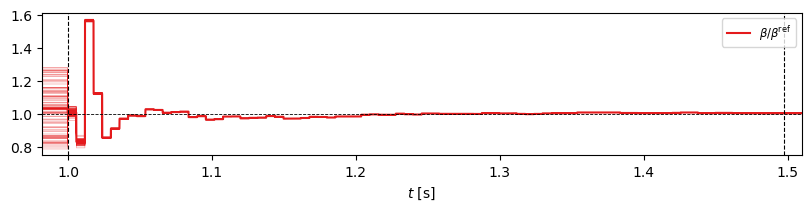

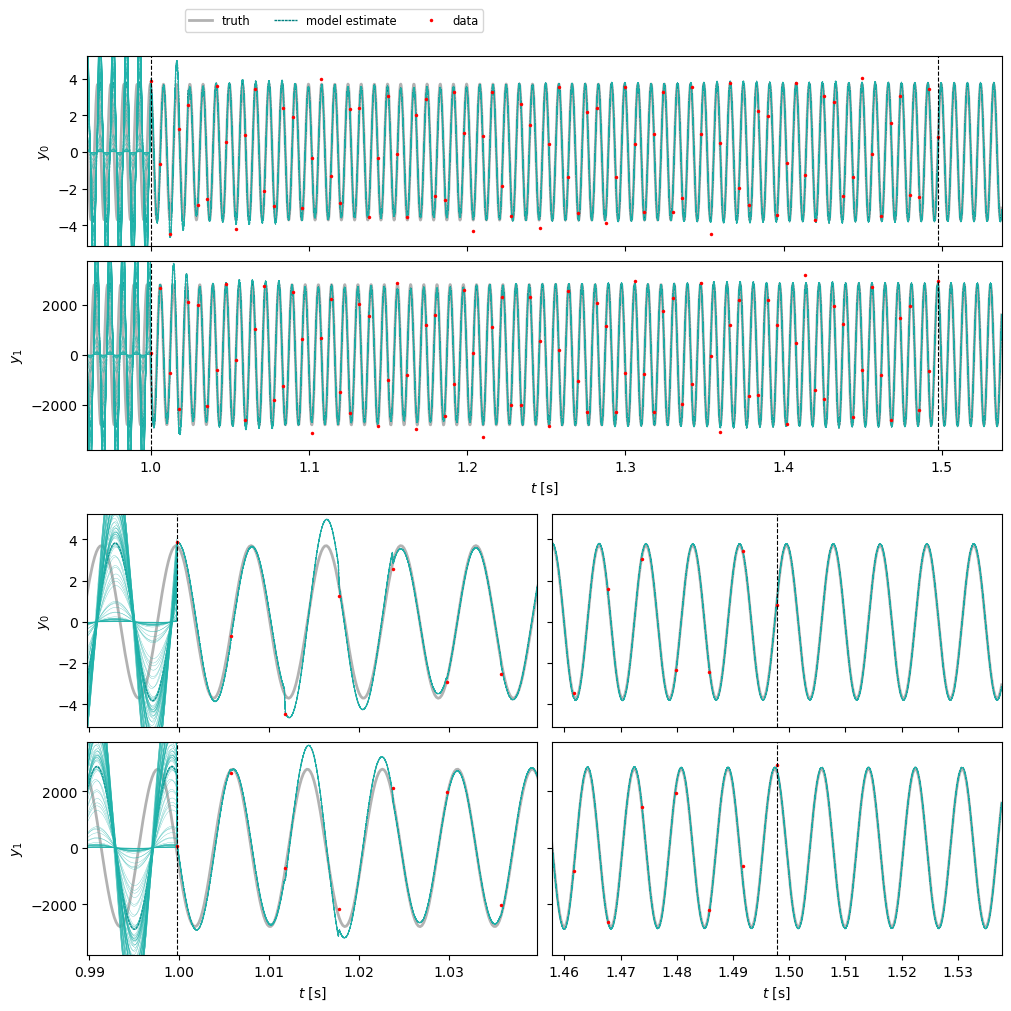

In [13]:
from essentials.plotResults import plot_timeseries, plot_parameters

plot_parameters(filter_ens, truth, 
                reference_p=alpha_true,  # If not provided plots unnormalized parameters
                plot_ensemble_members=True # If false plots mean and std
               )

plot_timeseries(filter_ens, truth, plot_ensemble_members=True)





<br />

___


### Exercises


<em> 
<font color=#7CB9E8> How would you expect the solution to change if we decrease/increase the number of uncertain parameters? 
    
<font color=#7CB9E8> How would you expect the solution to change if we decrease/increase the ensemble size (m) or the observation noise (std_d)?

</em>

___




What if the dynamics are chaotic? In [tutorial 02](02_Twin_Lorenz63.ipynb) we test the framework in a prototypical chaotic system, the Lorenz 63. 